# For testing

## Reports

```
from os.path import abspath
p=abspath('../output_paths.yaml')
print(p)

import os
os.chdir('../../../../')
from roux.global_imports import *

output_paths=read_dict(p)
print(output_paths)

cfg_method=read_dict(Path(output_paths['output']).parent.as_posix()+'/00_inputs/pam.yaml')
df01=read_table(output_paths['output_full'])
# df01.head(1)
import igv_notebook
igv_notebook.init()
b = igv_notebook.Browser({}).load_session(path=Path(output_paths['output']).parent.as_posix()+'/06_viz/igv_session_urls.json')
```

In [1]:
import pandas as pd
from roux.lib.io import read_table
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
## parameters
force=True

## `utils`

### `get_sequences`

In [2]:
## parameters
genome_path='inputs/dna.fa'
seq_len=20
df1=pd.DataFrame(dict(
    chrom=[4,4,],
    start=[101,101], # 1-based
    strand=['+','-'],
    ))
df1['end']=df1['start']+(seq_len-1)
_valid={'+': 'TATATTATTATATTATTATA', '-': 'TATAATAATATAATAATATA'}
df1

,chrom,start,strand,end
0,4,101,+,120
1,4,101,-,120


In [3]:
# %run ../beditor/lib/utils.py
from beditor.lib.utils import get_sequences

dfs={}
for k in [
    '2bit',
    'bedtools',
    'biopython'
    ]:
    dfs[k]=get_sequences(
        df1,
        genome_path=genome_path,
        method=k,
        p='test/get_sequences.bed',
        )
    # print(dfs[k])
df1=pd.concat(dfs,axis=0)
df1

INFO:root:using 2bit reference
INFO:root:using bedtools


test/get_sequences.fa


chrom  start  end         locus strand              sequence
2bit      0     4    100  120  4:100-120(+)      +  TATATTATTATATTATTATA
          1     4    100  120  4:100-120(-)      -  TATAATAATATAATAATATA
bedtools  0     4    100  120  4:100-120(+)      +  TATATTATTATATTATTATA
          1     4    100  120  4:100-120(-)      -  TATAATAATATAATAATATA
biopython 0     4    100  120  4:100-120(+)      +  TATATTATTATATTATTATA
          1     4    100  120  4:100-120(-)      -  TATAATAATATAATAATATA

In [4]:
assert all(df1['sequence'].apply(len)==seq_len)
df2=df1.drop_duplicates().reset_index(drop=True)
assert len(df2)==2,len(df2)
assert df2.set_index('strand')['sequence'].to_dict() == _valid, df2.set_index('strand')['sequence'].to_dict()

### `get_pos`

In [5]:
%run ../beditor/lib/utils.py
# from beditor.lib.utils import get_pos
ds1=get_pos(
    "ATG",
    "4:100-103(+)",
    # zero_based=True,
)
ds1

101    A
102    T
103    G
dtype: object

In [6]:
ds2=get_pos(
    "ATG",
    "4:101-103(+)",
    zero_based=False,
)
ds2

101    A
102    T
103    G
dtype: object

In [7]:
assert all(ds1==ds2)

## Visualizations

### `plot_ntcompos`

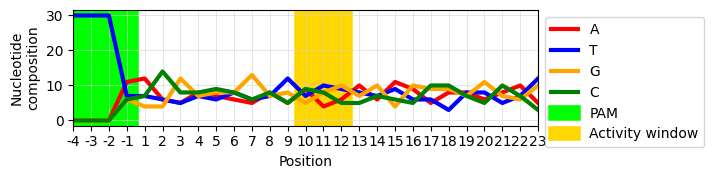

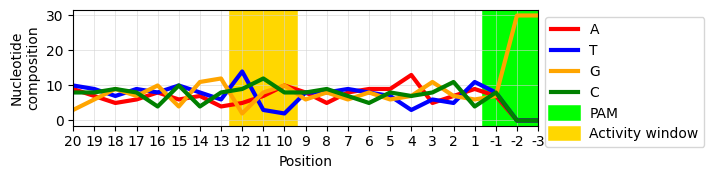

In [8]:
import numpy as np
d={
    ('up',4):['TTT'+(''.join(list(np.random.choice(['A','T','G','C'],24)))) for i in range(30)],
    ('down',3):[(''.join(list(np.random.choice(['A','T','G','C'],21))))+'GG' for i in range(30)],
    }
from beditor.lib.viz import plot_ntcompos
%run ../beditor/lib/viz.py
for (pam_pos,pam_len),v in d.items():
    fig,ax=plt.subplots(figsize=[6,1.5])
    plot_ntcompos(
        v,
        pam_pos=pam_pos,
        pam_len=pam_len,
        window=[10,12],
        ax=ax,
        )

### `plot_ontarget`

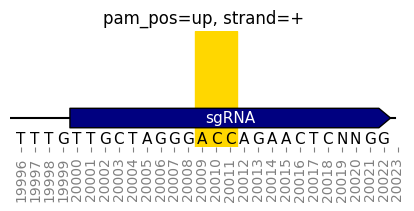

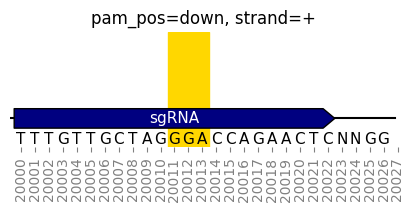

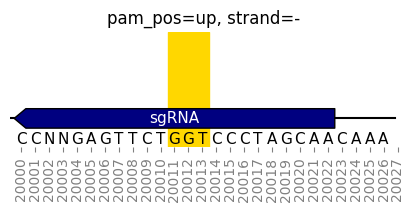

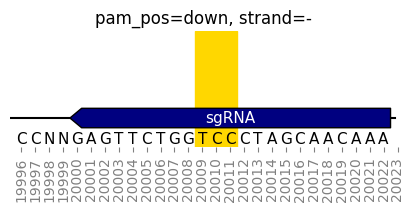

In [9]:
from beditor.lib.viz import plot_ontarget
%run ../beditor/lib/viz.py
for strand in ['+','-']:
    for pam_pos in ['up','down']:
        ax=plot_ontarget(
            guide_loc=f"1:20000-20023({strand})",
            pam_pos=pam_pos,
            pam_len=4,
            guidepam_seq="TTTGTTGCTAGGGACCAGAACTCNNGG",
            window= (10,12),
            show_title=False,
            figsize=[5,1.5],
            verbose=False,
            kws_sg={},
            )
        ax.set(title=f"pam_pos={pam_pos}, strand={strand}")

### `plot_offtargets`

In [10]:
logging.basicConfig(level=logging.WARNING,force=True)

In [11]:
cytobands=pd.read_csv(
    "https://raw.githubusercontent.com/rraadd88/chrov/main/examples/inputs/cytobands.tsv",
    sep='\t',
)
cytobands.head(1)

,Unnamed: 0,chromosome,p start,q end,start,end,cytoband,cytoband type,arm,chromosome arm
0,0,1,121700001,125100000,1,2300000,p36.33,gneg,p,chr1p


In [12]:
## demo data
data=pd.DataFrame(
    {
        'chromosome':['9','2','4','15','X'],
        'aligned start': [200000,1444,254454,1e5,1e7],
        'label': ['on','off','off','off','off'],
        'score per alignment': [1,0.3,0.5,0.3,0.0],
    },
)
data

,chromosome,aligned start,label,score per alignment
0,9,200000.0,on,1.0
1,2,1444.0,off,0.3
2,4,254454.0,off,0.5
3,15,100000.0,off,0.3
4,X,10000000.0,off,0.0


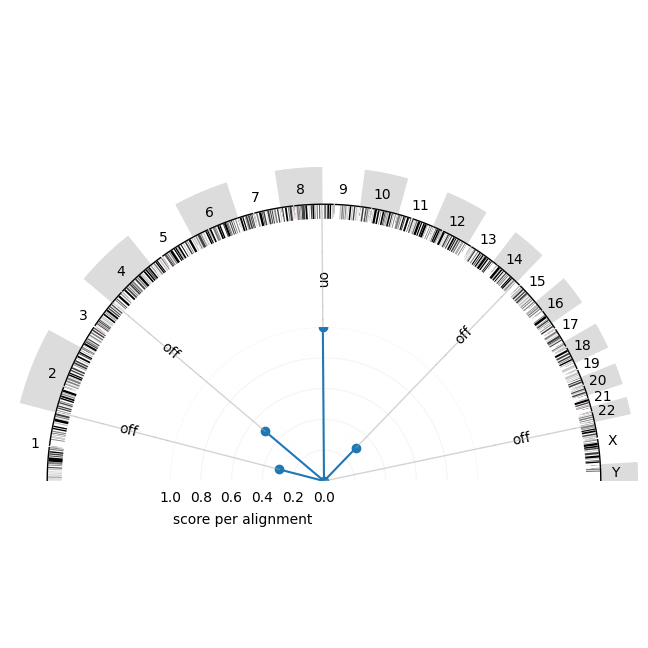

In [13]:
# %run ../../chrov/chrov/viz/figure.py
from chrov.viz.figure import plot_with_genome

coly='score per alignment'
axs=plot_with_genome(
    data=data.copy(),
    cytobands=cytobands,
    kind='stem',
    colx='aligned start',
    coly=coly,
    col_label='label',
    # coffy=0.9,
    xkind='loci',
    chrom_y=0,
    arc=True,
    va='center',
    off=0.8,
    offy=0.4,
    figsize=[4,4],
    kws_seaborn={},
    kws_annot_chroms={},
    kws_annot_labels=dict(loc='in'),
    )
axs['data'].set(ylim=[0,1])
#todo adjust in chrov
for t in axs['data'].get_children():
    if isinstance(t,plt.Text):
        if t.get_text()==coly:
            t.set_text(f"\n\n{t.get_text()}")
            t.set_x(0)
            break

## `gui`

In [51]:
from pathlib import Path
from roux.lib.io import read_ps,read_dict
parameters_list=[]
for p in read_ps("outputs/*/*/config.yaml"):
    parameters_list.append(dict(config_path=p))
len(parameters_list)

10

In [42]:
from papermill import execute_notebook
for params in parameters_list:
    # if not Path(params['output_path']).exists() or force:
        # logging.info(params['output_path'])
    outp=Path(read_dict(params['config_path'])['run']['output_path']).parent.as_posix()+'/gui.ipynb'
    # if outp!='outputs/protein/regions/gui.ipynb':
    #     continue
    print(outp)
    if not Path(outp).wiith_suffix('.log').exists() or force:
        execute_notebook(
            input_path='../beditor/beditor.ipynb',
            output_path=outp,
            parameters={**params,**dict(dbug=True)},
        )
    # break

outputs/base/points/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

outputs/base/positions/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

outputs/base/regions/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

outputs/base_not_be/positions/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

outputs/base_not_be/regions/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

outputs/protein/points/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

outputs/protein/positions/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

outputs/protein/regions/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

outputs/protein_not_be/positions/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

outputs/protein_not_be/regions/gui.ipynb


Executing:   0%|          | 0/92 [00:00<?, ?cell/s]

In [50]:
from shutil import copyfile
Path('test/').mkdir(parents=True,exist_ok=True)
for p in read_ps("outputs/*/*/config.yaml"):
    copyfile(p,'test/'+p.replace('/','_'))